# Predicción uso de bicicletas
Autores:
- Pau Adell Raventos
- Joan Sales De Marcos
- Iván González Reguera
- José Morote García

In [58]:
!pip install apafib --upgrade --user --quiet
!pip install scikit-optimize
!pip install dtreeviz

In [59]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from sklearn import set_config
import warnings
set_config(display='text')
warnings.filterwarnings('ignore')
plt.rcParams.update({'font.size': 16})
pd.set_option('display.precision', 3)
import numpy as np
from sklearn.decomposition import PCA
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from yellowbrick.regressor import prediction_error

from IPython.display import display, HTML
show_html = lambda html: display(HTML(html))

In [60]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [61]:
def find_folder(folder_name, start_path='/content/drive/My Drive'):
    for root, dirs, files in os.walk(start_path):
        if folder_name in dirs:
            return os.path.join(root, folder_name)

    return None

shared_folder_path = find_folder("APA")

bike_folder_path = os.path.join(shared_folder_path, "bike+sharing+dataset")

def list_contents(directory_path):
    return os.listdir(directory_path)

contents = list_contents(bike_folder_path)
contents

['hour.csv', 'day.csv', 'Readme.txt']

In [62]:
dataset = pd.read_csv(bike_folder_path + "/day.csv", header=0, delimiter=',')
dataset.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344,0.364,0.806,0.160,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363,0.354,0.696,0.249,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196,0.189,0.437,0.248,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200,0.212,0.590,0.160,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.227,0.229,0.437,0.187,82,1518,1600


In [63]:
dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
instant,731.0,366.000,211.166,1.000,183.500,366.000,548.500,731.000
season,731.0,2.497,1.111,1.000,2.000,3.000,3.000,4.000
yr,731.0,0.501,0.500,0.000,0.000,1.000,1.000,1.000
mnth,731.0,6.520,3.452,1.000,4.000,7.000,10.000,12.000
holiday,731.0,0.029,0.167,0.000,0.000,0.000,0.000,1.000
weekday,731.0,2.997,2.005,0.000,1.000,3.000,5.000,6.000
workingday,731.0,0.684,0.465,0.000,0.000,1.000,1.000,1.000
weathersit,731.0,1.395,0.545,1.000,1.000,1.000,2.000,3.000
temp,731.0,0.495,0.183,0.059,0.337,0.498,0.655,0.862
atemp,731.0,0.474,0.163,0.079,0.338,0.487,0.609,0.841


## Apartado A

### Separación de datos

In [64]:
train, test = train_test_split(dataset, test_size=0.4, random_state=42)
train.shape, test.shape

((438, 16), (293, 16))

<Figure size 1200x600 with 0 Axes>

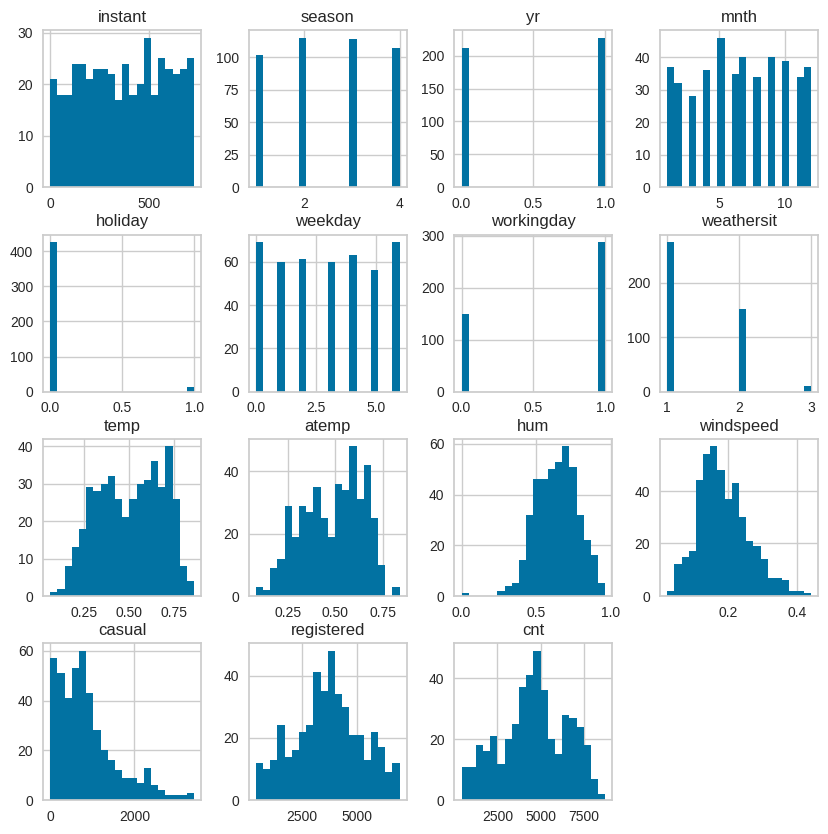

In [65]:
plt.figure(figsize=(12,6))
train.loc[:,:].hist(bins=20, figsize=(10,10));

Podemos observar como las variables numéricas siguen generalmente una distribución gaussiana. En cuanto a las variables categóricas, a excepción de *weathersit* el resto están balanceadas, con misma cantidad de casos en todas las categorías.

### Preprocesado set de entrenamiento
##### Variables numéricas

Tal como se puede observar a continuación, las variables *instant* y *dteday* son identificadores, dado que tienen la misma cantidad de instancias diferentes que cantidad de muestras hay.

Además, también se procederá a eliminar las variables *casual* y *registered* dado que su suma es equivalente a la variable objetivo, por tanto estaríamos utilizando directamente la variable objetivo para predecir resultados si no las eliminaramos y la predicción se convertiría en una simple suma.

In [66]:
nunique_instant = train['instant'].nunique()
nunique_dteday = train['dteday'].nunique()
print("Valores unicos variable instant:", nunique_instant)
print("Valores unicos variable dteday:", nunique_dteday)

Valores unicos variable instant: 438
Valores unicos variable dteday: 438


In [67]:
vars_to_drop = ['instant', 'dteday', 'casual', 'registered']
train = train.drop(vars_to_drop, axis=1)
train.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
329,4,0,11,0,6,0,1,0.376,0.385,0.682,0.068,3068
153,2,0,6,0,5,1,1,0.620,0.587,0.354,0.253,5312
75,1,0,3,0,4,1,1,0.415,0.410,0.603,0.210,2744
377,1,1,1,0,5,1,1,0.274,0.249,0.507,0.378,3214
277,4,0,10,0,3,1,1,0.538,0.527,0.648,0.177,4826


Por último, leyendo la descripción del dataset nos damos cuenta de que las variables *temp* y *atemp* representan la misma información, y viendo el .describe() también observamos que sus valores son muy parecidos, por tanto únicamente necesitaremos una de estas dos variables. Para elegir cuál de ellas nos guiaremos por la correlación con la variable objetivo:

In [68]:
corr_temp_atemp_cnt = train[['temp', 'atemp', 'cnt']].corr()
corr_temp_atemp_cnt.loc['cnt', corr_temp_atemp_cnt.columns != 'cnt'].sort_values(ascending=False)

atemp    0.645
temp     0.637
Name: cnt, dtype: float64

Observamos como la variable *atemp* tiene ligeramente más correlación con la variable objetivo que *temp*, por consecuente nos quedaremos con la variable *atemp*.

In [69]:
train = train.drop(['temp'], axis=1)
train.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,atemp,hum,windspeed,cnt
329,4,0,11,0,6,0,1,0.385,0.682,0.068,3068
153,2,0,6,0,5,1,1,0.587,0.354,0.253,5312
75,1,0,3,0,4,1,1,0.410,0.603,0.210,2744
377,1,1,1,0,5,1,1,0.249,0.507,0.378,3214
277,4,0,10,0,3,1,1,0.527,0.648,0.177,4826


##### Variables categóricas
Ahora procedemos a ver si es necesario la eliminación de alguna variable categórica:

Leyendo de nuevo la descripción del dataset en https://archive.ics.uci.edu/dataset/275/bike+sharing+dataset , nos damos cuenta de que la variable *workingday* ya incluye la información de *holiday*, dado que mira si se trabaja o no, mientras que la segunda variable mira si es festivo o no. *Workingday* incluye la misma información pero añadiendo los fines de semana, por tanto nos quedaremos con esta variable.

In [70]:
train = train.drop(['holiday'], axis=1)
train.head()

,season,yr,mnth,weekday,workingday,weathersit,atemp,hum,windspeed,cnt
329,4,0,11,6,0,1,0.385,0.682,0.068,3068
153,2,0,6,5,1,1,0.587,0.354,0.253,5312
75,1,0,3,4,1,1,0.410,0.603,0.210,2744
377,1,1,1,5,1,1,0.249,0.507,0.378,3214
277,4,0,10,3,1,1,0.527,0.648,0.177,4826


#### Valores perdidos

Procedemos a ver si el dataset contiene valores perdidos:

In [71]:
train.isna().sum()

season        0
yr            0
mnth          0
weekday       0
workingday    0
weathersit    0
atemp         0
hum           0
windspeed     0
cnt           0
dtype: int64

Observamos como no tiene ningún valor perdido.

#### Valores extremos

Ahora procedemos a ver si tiene valores extremos y, en caso de existir, cómo tratarlos:

<Axes: >

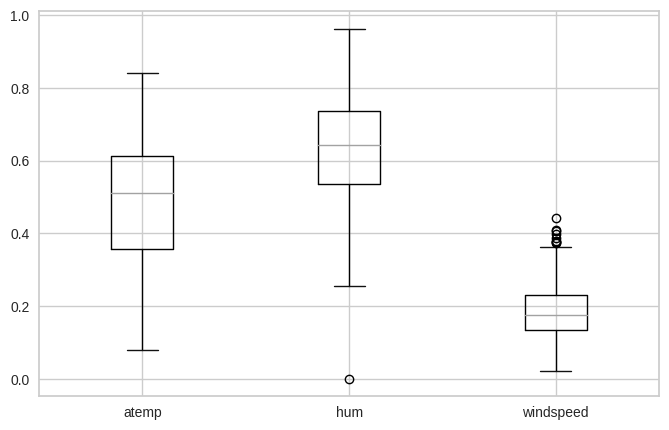

In [72]:
fig, ax = plt.subplots(figsize=(8,5))
train[['atemp', 'hum', 'windspeed']].boxplot()

Observamos la presencia de valores extremos en la variable *windspeed*.

Estos valores pueden indicar dias de fuertes rachas de viento, lo que nos aporta información ya que esos dias la cantidad de bicicletas será baja, por tanto, procedemos a dejarlos en el dataset.

Observamos también la presencia de valores extremos en la variable *hum*, en este caso indicando dias sin nada de humedad, por tanto, como también aportan información, procedemos a dejarlos.

#### One-Hot Encoding

Ahora procedemos a realizar One-Hot Encoding a las variables categóricas que no sean binarias, para evitar relaciones de orden en las variables.

In [73]:
y_train = train['cnt']
X_train = train.loc[:, train.columns != 'cnt']
X_train.head()

,season,yr,mnth,weekday,workingday,weathersit,atemp,hum,windspeed
329,4,0,11,6,0,1,0.385,0.682,0.068
153,2,0,6,5,1,1,0.587,0.354,0.253
75,1,0,3,4,1,1,0.410,0.603,0.210
377,1,1,1,5,1,1,0.249,0.507,0.378
277,4,0,10,3,1,1,0.527,0.648,0.177


In [74]:
vars_to_onehot = ['season', 'mnth', 'weekday', 'weathersit']

X_train_onehot = X_train.copy()

# si dropfirst entonces las que sean 0 en todas las columnas son la que se ha eliminado, pero tambien las ignoradas en handleunknown
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
X_train_onehot_dummies = encoder.fit_transform(X_train_onehot[vars_to_onehot])

new_columns = encoder.get_feature_names_out(vars_to_onehot)
X_train_onehot_dummies = pd.DataFrame(X_train_onehot_dummies, columns=new_columns).astype(int)

X_train_onehot.drop(columns=vars_to_onehot, axis=1, inplace=True)

X_train_onehot.reset_index(drop=True, inplace=True)
X_train_onehot_dummies.index = X_train_onehot.index

X_train_onehot = pd.concat([X_train_onehot, X_train_onehot_dummies], axis=1)

y_train.reset_index(drop=True, inplace=True)

X_train_onehot.head()

,yr,workingday,atemp,hum,windspeed,season_1,season_2,season_3,season_4,mnth_1,...,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_1,weathersit_2,weathersit_3
0,0,0,0.385,0.682,0.068,0,0,0,1,0,...,0,0,0,0,0,0,1,1,0,0
1,0,1,0.587,0.354,0.253,0,1,0,0,0,...,0,0,0,0,0,1,0,1,0,0
2,0,1,0.410,0.603,0.210,1,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
3,1,1,0.249,0.507,0.378,1,0,0,0,1,...,0,0,0,0,0,1,0,1,0,0
4,0,1,0.527,0.648,0.177,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,0


In [75]:
y_train.head()

0    3068
1    5312
2    2744
3    3214
4    4826
Name: cnt, dtype: int64

### Preproceso set de test

Aplicamos exactamente el mismo preproceso al set de test:

In [76]:
test = test.drop(vars_to_drop + ['temp'] + ['holiday'], axis=1)

y_test= test['cnt']
X_test = test.loc[:, test.columns != 'cnt']

X_test_onehot = X_test.copy()

X_test_onehot_dummies = encoder.transform(X_test_onehot[vars_to_onehot])

new_columns = encoder.get_feature_names_out(vars_to_onehot)
X_test_onehot_dummies = pd.DataFrame(X_test_onehot_dummies, columns=new_columns).astype(int)

X_test_onehot.drop(columns=vars_to_onehot, axis=1, inplace=True)

X_test_onehot.reset_index(drop=True, inplace=True)
X_test_onehot_dummies.index = X_test_onehot.index

X_test_onehot = pd.concat([X_test_onehot, X_test_onehot_dummies], axis=1)

y_test.reset_index(drop=True, inplace=True)

X_test_onehot.head()

,yr,workingday,atemp,hum,windspeed,season_1,season_2,season_3,season_4,mnth_1,...,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_1,weathersit_2,weathersit_3
0,1,1,0.469,0.734,0.174,0,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0
1,0,1,0.178,0.438,0.278,1,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
2,0,1,0.319,0.586,0.229,0,0,0,1,0,...,0,0,0,0,0,1,0,0,1,0
3,1,0,0.417,0.676,0.172,0,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0
4,1,1,0.544,0.570,0.236,0,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0


## Apartado B

### DecisionTreeRegressor

In [77]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor(random_state=42)

parametros = {
    'criterion': ["squared_error", "friedman_mse", "poisson", "absolute_error"],
    'splitter': ["best", "random"],
    'max_depth': [1, 2, 5, 8, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5, 10],
    'max_features': ["auto", "sqrt", "log2"]
}

In [78]:
from skopt import BayesSearchCV
bayes_search_dt = BayesSearchCV(dt, parametros, cv=5, n_jobs = -1, random_state=42)
bayes_search_dt.fit(X_train_onehot, y_train)

BayesSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
              random_state=42,
              search_spaces={'criterion': ['squared_error', 'friedman_mse',
                                           'poisson', 'absolute_error'],
                             'max_depth': [1, 2, 5, 8, 10, 15, 20, None],
                             'max_features': ['auto', 'sqrt', 'log2'],
                             'min_samples_leaf': [1, 2, 3, 4, 5, 10],
                             'min_samples_split': [2, 5, 10],
                             'splitter': ['best', 'random']})

In [79]:
show_html(pd.DataFrame(bayes_search_dt.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
45,"{'criterion': 'poisson', 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 10, 'min_samples_split': 10, 'splitter': 'random'}",0.776,1
32,"{'criterion': 'poisson', 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 10, 'min_samples_split': 2, 'splitter': 'random'}",0.776,1
46,"{'criterion': 'poisson', 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 5, 'min_samples_split': 10, 'splitter': 'random'}",0.775,3
40,"{'criterion': 'poisson', 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 3, 'min_samples_split': 10, 'splitter': 'random'}",0.773,4
39,"{'criterion': 'friedman_mse', 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 10, 'min_samples_split': 10, 'splitter': 'random'}",0.773,5


Podemos ver como hemos obtenido un valor de mean_test_score de 0.776, un valor bastante aceptable inicialmente. Los hiperparámetros que hemos encontrado como óptimos han sido utilizando una profundidad máxima de 5, usando de función de calidad la del error cuadrático, como mínimo de muestras en una hoja 10 y mínimo de muestras para separar un nodo interno de 10. Además hemos usado como estrategia para escoger las separaciones "best", que escoje las mejores separaciones.

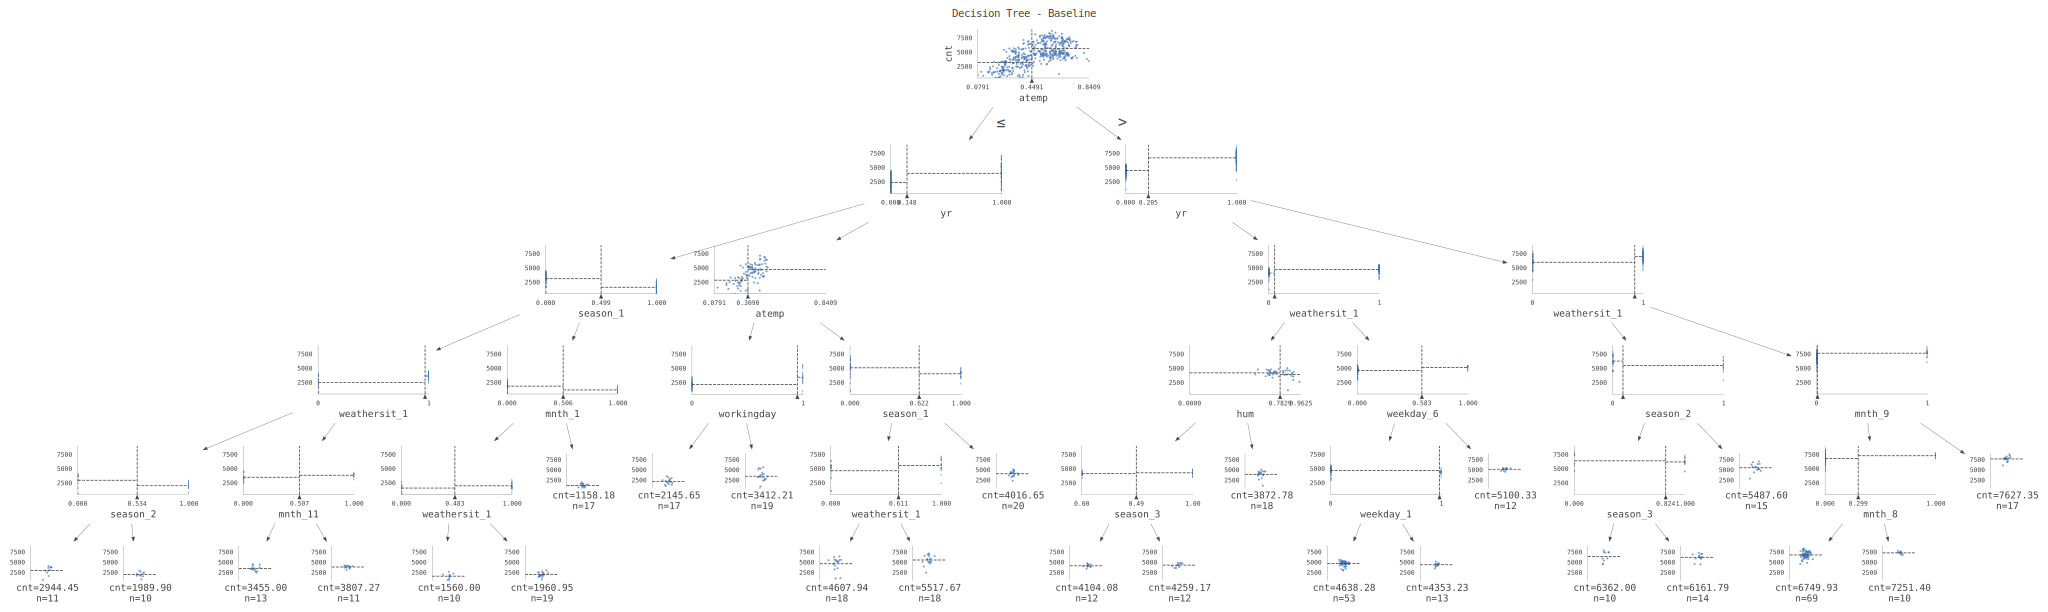

In [80]:
import dtreeviz

mejor_modelo_dt = bayes_search_dt.best_estimator_
v_model = dtreeviz.model(mejor_modelo_dt,
               X_train=X_train_onehot,
               y_train=y_train,
               target_name='cnt',
               feature_names=X_train_onehot.columns,
               class_names= [str(var) for var in sorted(y_train.unique())]
               )
v_model.view(fontname="monospace", scale=1.5, title="Decision Tree - Baseline",orientation='TD')

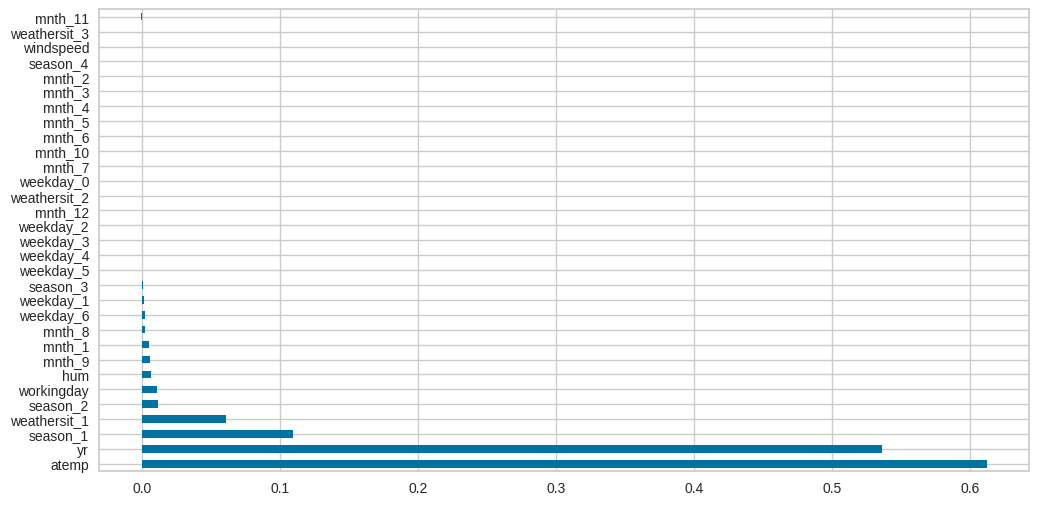

In [102]:
from numpy.random import choice
from sklearn.inspection import permutation_importance

c = choice(X_test_onehot.shape[0], size=X_test_onehot.shape[0], replace=False)
pi = permutation_importance(bayes_search_dt.best_estimator_, X_test_onehot.iloc[c,:], y_test.to_numpy()[c], n_jobs=-1, random_state=42)
var_imp = pd.DataFrame({'importance':pi.importances_mean}, index=X_train_onehot.columns)
var_imp.sort_values(by='importance', ascending=False).plot.barh(figsize=(12,6), legend=False);

Lo primero que se puede observar, es que la parte superior del árbol de decisión es determinada con las variables que más peso ha asignado.

Podemos ver como primero divide los datos en dos categorias dependiendo si su atemp es mayor 0.4491 o menor igual.

Seguidamente, en cada caso procede a mirar el año en que se encuentran los datos, y después, para cada uno de estos subárboles generados, ya sigue una estrategia diferente para cada uno de ellos: por la izquierda contempla season_1 y atemp, mientras que por la derecha weathersit_1. A partir de aqui ya entran en juego las variables con menor peso asignado.

En otras palabras, cuanto más importante es una variable y más peso se le ha asignado en el árbol, más común es en las partes superiores, mientras que si se le ha asignado poco peso es más común en las partes inferiores.

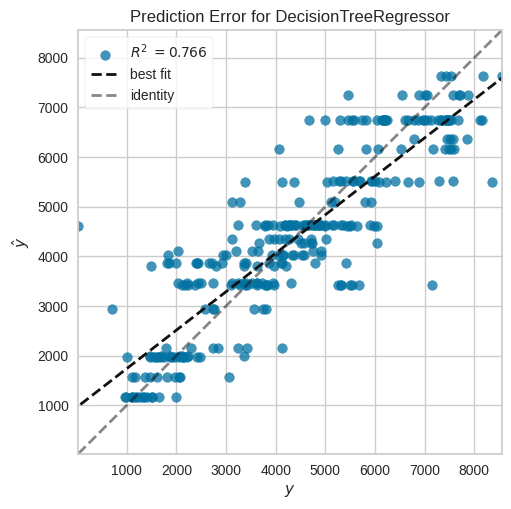

PredictionError(ax=<Axes: title={'center': 'Prediction Error for DecisionTreeRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>,
                estimator=DecisionTreeRegressor(criterion='poisson',
                                                max_depth=5,
                                                max_features='auto',
                                                min_samples_leaf=10,
                                                random_state=42,
                                                splitter='random'))

In [81]:
from sklearn.metrics import r2_score
prediction_error(bayes_search_dt.best_estimator_, X_train_onehot, y_train, X_test_onehot, y_test)

Podemos ver que la R2 que obtenemos es de 0.766 que no está mal, pero lo que destaca a primera vista es el extraño patrón de las predicciones hechas por el modelo, esto es debido a que el modelo de DecisionTreeRegressor asigna el mismo valor a todas las predicciones que caen en una hoja del arbol segun los nodos que ha seguido, como hemos visto anteriormente algunos ejemplo, y todas las muestras de test que caigan la misma hoja obtendran el mismo valor. Es por eso que vemos un scatterplot por filas, dado que cada fila es una hoja y da esta manera de predecir donde tenemos diversos rangos de predicciones en el mismo valor.

In [82]:
y_pred = bayes_search_dt.best_estimator_.predict(X_test_onehot)
unique_values = np.unique(y_pred)
print("Cantidad de valores unicos:", len(unique_values))
print("Valores unicos:", unique_values)

Cantidad de valores unicos: 24
Valores unicos: [1158.17647059 1560.         1960.94736842 1989.9        2145.64705882
 2944.45454545 3412.21052632 3455.         3807.27272727 3872.77777778
 4016.65       4104.08333333 4259.16666667 4353.23076923 4607.94444444
 4638.28301887 5100.33333333 5487.6        5517.66666667 6161.78571429
 6362.         6749.92753623 7251.4        7627.35294118]


In [83]:
tree_unique_values = np.unique(bayes_search_dt.best_estimator_.tree_.value)
tree_unique_values

array([1158.17647059, 1560.        , 1577.10869565, 1822.68965517,
       1960.94736842, 1989.9       , 2145.64705882, 2325.6043956 ,
       2489.9047619 , 2814.11111111, 2944.45454545, 3090.73333333,
       3144.98360656, 3412.21052632, 3455.        , 3616.45833333,
       3807.27272727, 3872.77777778, 3955.45652174, 4016.65      ,
       4049.26190476, 4104.08333333, 4181.625     , 4259.16666667,
       4353.23076923, 4447.45      , 4582.13636364, 4587.55479452,
       4607.94444444, 4638.28301887, 4661.85897436, 4689.17857143,
       5062.80555556, 5100.33333333, 5487.6       , 5517.66666667,
       5622.81176471, 5953.82051282, 6161.78571429, 6245.20833333,
       6362.        , 6667.57777778, 6749.92753623, 6813.40506329,
       6957.54166667, 7251.4       , 7627.35294118])

In [84]:
np.array_equal(np.intersect1d(unique_values, tree_unique_values), unique_values)

True

Podemos ver como todos los valores únicos de la predicción se encuentran dentro de los posibles valores de la variable 'cnt' generados por el árbol, confirmando este fenómeno.

## Apartado C

### RandomForestRegressor

In [85]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=42)

parametros = {
    'n_estimators': [5, 10, 25, 40, 50, 75, 100, 200],
    'max_depth': [1, 2, 5, 8, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5, 10],
}

In [86]:
bayes_search_rf = BayesSearchCV(rf, parametros, cv=5, n_jobs = -1, random_state=42)
bayes_search_rf.fit(X_train_onehot, y_train)

BayesSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
              random_state=42,
              search_spaces={'max_depth': [1, 2, 5, 8, 10, 15, 20, None],
                             'min_samples_leaf': [1, 2, 3, 4, 5, 10],
                             'min_samples_split': [2, 5, 10],
                             'n_estimators': [5, 10, 25, 40, 50, 75, 100, 200]})

In [87]:
show_html(pd.DataFrame(bayes_search_rf.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
49,"{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 25}",0.837,1
48,"{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 40}",0.836,2
45,"{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 40}",0.836,2
14,"{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}",0.835,4
28,"{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}",0.835,5


Hemos obtenido mejores resultados que con el modelo anterior, alcanzando 0.837 de mean_test_score. En este caso los mejores hiperparámetros son usar 25 árboles en un bosque, sin profundidad máxima y como mínimo de muestras en una hoja tan solo 1 y mínimo de muestras para separar un nodo interno de 2, igual que antes.

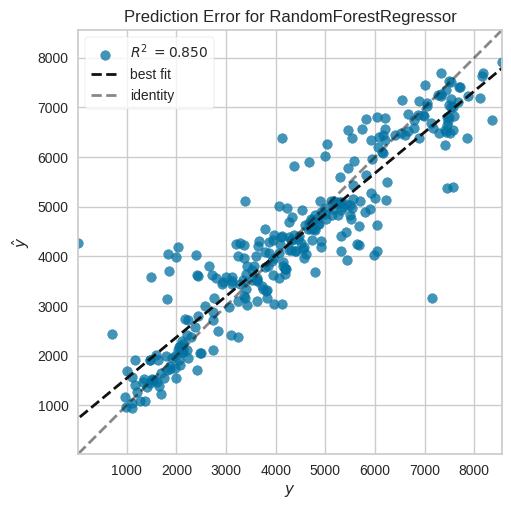

PredictionError(ax=<Axes: title={'center': 'Prediction Error for RandomForestRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>,
                estimator=RandomForestRegressor(n_estimators=25,
                                                random_state=42))

In [88]:
from sklearn.metrics import r2_score
prediction_error(bayes_search_rf.best_estimator_, X_train_onehot, y_train, X_test_onehot, y_test)

La R2 obtenida también es mejor, obteniendo 0.850, un valor que ya es más que aceptable, además es muy parecida al mean_test_score, lo que es buena señal.

Podemos ver claramente como ya no tenemos ese extraño fenómeno en el grafo ya que aquí las predicciones son totalmente únicas, cada valor predicho es diferente entre sí ya que el randomForestRegressor no asigna el mismo valor a más de una predicción como el anterior modelo, ya que se hace la media entre las predicciones de todos los árboles de decisión generados aleatoriamente.

### GradientBoostingRegressor

In [89]:
from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor(random_state=42)

parametros_gb ={'n_estimators':[10, 100, 250, 500, 1000],
        'learning_rate':[.001, 0.01, .1, 1],
        'max_depth':[1, 2, 5, 10],
        'subsample':[.5,.75,1],
        'loss':['squared_error', 'absolute_error']
}

In [90]:
#from skopt import BayesSearchCV
bayes_search_gb = BayesSearchCV(gb, parametros_gb, refit=True, cv=5, n_jobs=-1, random_state=42)
bayes_search_gb.fit(X_train_onehot, y_train)

BayesSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
              n_jobs=-1, random_state=42,
              search_spaces={'learning_rate': [0.001, 0.01, 0.1, 1],
                             'loss': ['squared_error', 'absolute_error'],
                             'max_depth': [1, 2, 5, 10],
                             'n_estimators': [10, 100, 250, 500, 1000],
                             'subsample': [0.5, 0.75, 1]})

In [91]:
show_html(pd.DataFrame(bayes_search_gb.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
49,"{'learning_rate': 0.1, 'loss': 'absolute_error', 'max_depth': 2, 'n_estimators': 250, 'subsample': 0.75}",0.864,1
47,"{'learning_rate': 0.1, 'loss': 'absolute_error', 'max_depth': 2, 'n_estimators': 250, 'subsample': 0.75}",0.864,1
46,"{'learning_rate': 0.1, 'loss': 'absolute_error', 'max_depth': 2, 'n_estimators': 250, 'subsample': 0.75}",0.864,1
45,"{'learning_rate': 0.1, 'loss': 'absolute_error', 'max_depth': 2, 'n_estimators': 250, 'subsample': 0.75}",0.864,1
44,"{'learning_rate': 0.1, 'loss': 'absolute_error', 'max_depth': 2, 'n_estimators': 250, 'subsample': 0.75}",0.864,1


Vemos un resultado aún mejor con el gradient boosting, llegando a un valor de
mean_test_score de 0.864, muy alto en este caso. Los hiperparámetros utilizados
han sido una tasa de aprendizaje de 0.1, de función de pérdida el error absoluto, una profundidad máxima de 2 y 1000 etapas de refuerzo (boosting) que es un número bastante elevado. Como submuestra hemos usado 0.75 y cuando este valor es inferior a 1 se utiliza refuerzo por gradiente estocástico.

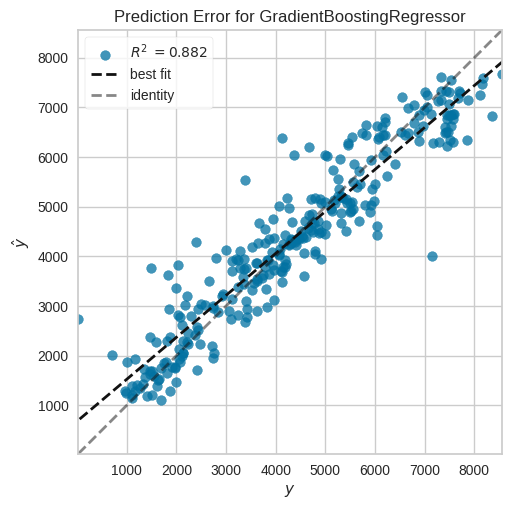

PredictionError(ax=<Axes: title={'center': 'Prediction Error for GradientBoostingRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>,
                estimator=GradientBoostingRegressor(loss='absolute_error',
                                                    max_depth=2,
                                                    n_estimators=250,
                                                    random_state=42,
                                                    subsample=0.75))

In [92]:
from sklearn.metrics import r2_score
prediction_error(bayes_search_gb.best_estimator_, X_train_onehot, y_train, X_test_onehot, y_test)

La R2 también ha mejorado sustancialmente, obteniendo 0.882, aquí ya podemos ver como los datos se ajustan de manera correcta a la recta de mejor fit, lo cual indica que estamos prediciendo de manera correcta los datos de test. Seguimos teniendo unos pocos valores alejados con una predicción incorrecta pero el modelo ya es muy preciso.

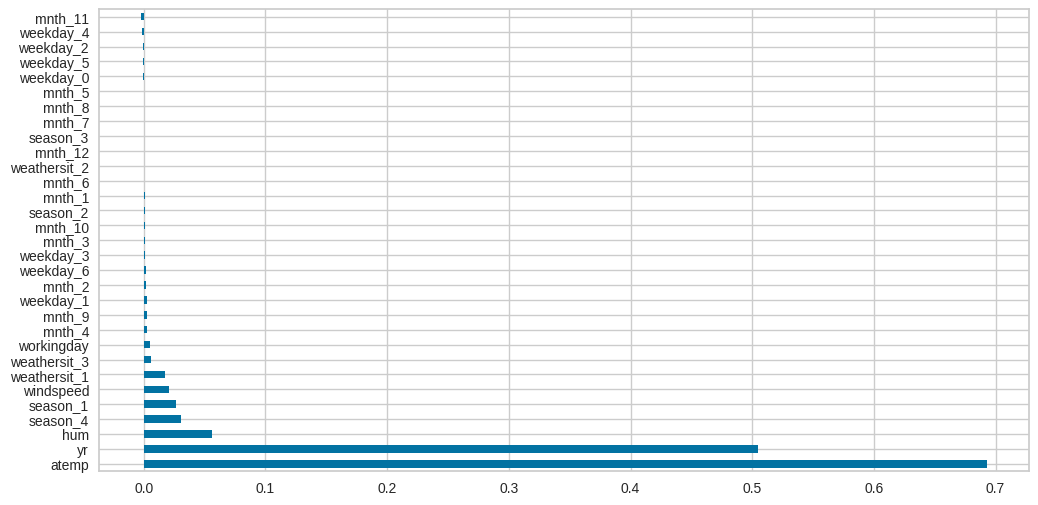

In [93]:
from numpy.random import choice
from sklearn.inspection import permutation_importance

c = choice(X_test_onehot.shape[0], size=X_test_onehot.shape[0], replace=False)
pi = permutation_importance(bayes_search_rf, X_test_onehot.iloc[c,:], y_test.to_numpy()[c], n_jobs=-1, random_state=42)
var_imp = pd.DataFrame({'importance':pi.importances_mean}, index=X_train_onehot.columns)
var_imp.sort_values(by='importance', ascending=False).plot.barh(figsize=(12,6), legend=False);

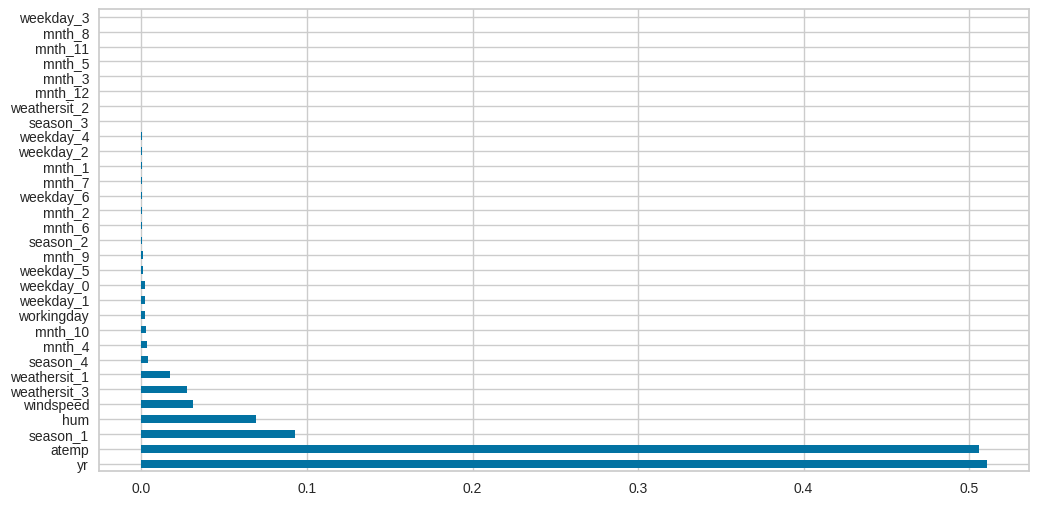

In [94]:
c = choice(X_test_onehot.shape[0], size=X_test_onehot.shape[0], replace=False)
pi = permutation_importance(bayes_search_gb, X_test_onehot.iloc[c,:], y_test.to_numpy()[c], n_jobs=-1, random_state=42)
var_imp = pd.DataFrame({'importance':pi.importances_mean}, index=X_train_onehot.columns)
var_imp.sort_values(by='importance', ascending=False).plot.barh(figsize=(12,6), legend=False);

Estos dos modelos son mejores que el árbol de regresión, dado que combinando las decisiones de regresores débiles permite recoger mayor varianza, dado que cada uno tiene un punto de vista diferente, lo que permite obtener un mejor acierto general. Además estos métodos suelen ser más robustos a datos con ruido, lo que conjuntamente con lo mencionado en la frase anterior, permiten una mayor generalización de los datos.

En cuanto a las importancias de las variables encontramos diferencias sustanciales, pero también similitudes. Ambos modelos le dan una gran importancia a atemp y year, siendo en el primer caso atemp la variable con más importancia y year la segunda, y girando los puestos en el segundo caso.

Lo mismo pasa con las variables en los puestos 3 y 4, donde ambos coinciden en hum y season_1 pero cambiando de puesto una vez más.

Podemos ver como las variables escogidas como más importantes ya estaban presentes en el primer modelo, ya que primero separaba según atemp, luego a los de una rama según year y a los de la otra según season_1, para acabar utilizando hum. Así que el modelo estaba bien encaminado en ese aspecto.

## Apartado D

### Estandarización

Primero vamos a estandarizar los datos para poder utilizar el kernel RBF

In [95]:
from sklearn.preprocessing import StandardScaler

vars_to_standarize = ['atemp', 'hum', 'windspeed']

scaler = StandardScaler()
X_train_scaled = X_train_onehot.copy()

X_train_scaled.loc[:,vars_to_standarize] = scaler.fit_transform(X_train_scaled.loc[:, vars_to_standarize])
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_scaled.columns)

X_train_scaled.head()

,yr,workingday,atemp,hum,windspeed,season_1,season_2,season_3,season_4,mnth_1,...,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_1,weathersit_2,weathersit_3
0,0,0,-0.617,0.319,-1.625,0,0,0,1,0,...,0,0,0,0,0,0,1,1,0,0
1,0,1,0.646,-2.030,0.888,0,1,0,0,0,...,0,0,0,0,0,1,0,1,0,0
2,0,1,-0.459,-0.246,0.296,1,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
3,1,1,-1.466,-0.930,2.589,1,0,0,0,1,...,0,0,0,0,0,1,0,1,0,0
4,0,1,0.271,0.076,-0.144,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,0


In [96]:
X_test_scaled = X_test_onehot.copy()

X_test_scaled.loc[:,vars_to_standarize] = scaler.transform(X_test_scaled.loc[:, vars_to_standarize])
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test_scaled.columns)

X_test_scaled.head()

,yr,workingday,atemp,hum,windspeed,season_1,season_2,season_3,season_4,mnth_1,...,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_1,weathersit_2,weathersit_3
0,1,1,-0.092,0.692,-0.187,0,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0
1,0,1,-1.913,-1.430,1.223,1,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
2,0,1,-1.032,-0.369,0.566,0,0,0,1,0,...,0,0,0,0,0,1,0,0,1,0
3,1,0,-0.416,0.280,-0.212,0,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0
4,1,1,0.378,-0.482,0.660,0,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0


### SVR con kernel RBF

In [97]:
from sklearn.svm import SVR
svr_rbf = SVR(kernel='rbf', max_iter=25000)

parametros = {
    'C':10**np.linspace(-1,4,50),
    'degree':[2,3],
    'epsilon': [1, 1.5, 2, 2.5, 3, 3.5, 4, 5, 5.5, 6, 6.5, 7, 8, 9],
    'coef0': [1, 10, 20]
}

In [98]:
svr_rbf_bayes_search = BayesSearchCV(svr_rbf, parametros, cv=5, n_jobs = -1, random_state=42)
svr_rbf_bayes_search.fit(X_train_scaled, y_train)

BayesSearchCV(cv=5, estimator=SVR(max_iter=25000), n_jobs=-1, random_state=42,
              search_spaces={'C': array([1.00000000e-01, 1.26485522e-01, 1.59985872e-01, 2.02358965e-01,
       2.55954792e-01, 3.23745754e-01, 4.09491506e-01, 5.17947468e-01,
       6.55128557e-01, 8.28642773e-01, 1.04811313e+00, 1.32571137e+00,
       1.67683294e+00, 2.12095089e+00, 2.68269580e+00, 3.39322177e+00,
       4.2919342...
       1.84206997e+02, 2.32995181e+02, 2.94705170e+02, 3.72759372e+02,
       4.71486636e+02, 5.96362332e+02, 7.54312006e+02, 9.54095476e+02,
       1.20679264e+03, 1.52641797e+03, 1.93069773e+03, 2.44205309e+03,
       3.08884360e+03, 3.90693994e+03, 4.94171336e+03, 6.25055193e+03,
       7.90604321e+03, 1.00000000e+04]),
                             'coef0': [1, 10, 20], 'degree': [2, 3],
                             'epsilon': [1, 1.5, 2, 2.5, 3, 3.5, 4, 5, 5.5, 6,
                                         6.5, 7, 8, 9]})

In [99]:
show_html(pd.DataFrame(svr_rbf_bayes_search.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
49,"{'C': 1930.6977288832495, 'coef0': 20, 'degree': 2, 'epsilon': 9.0}",0.861,1
33,"{'C': 1930.6977288832495, 'coef0': 20, 'degree': 2, 'epsilon': 9.0}",0.861,1
32,"{'C': 1930.6977288832495, 'coef0': 20, 'degree': 3, 'epsilon': 9.0}",0.861,1
31,"{'C': 1930.6977288832495, 'coef0': 1, 'degree': 3, 'epsilon': 9.0}",0.861,1
28,"{'C': 1930.6977288832495, 'coef0': 1, 'degree': 2, 'epsilon': 9.0}",0.861,1


Para fitear este modelo escogimos de valores de C hasta 10^3, pero como todos los mejores estimadores estaban utilizando una C con valor 1000 decidimos aumentar la búsqueda hasta 10^4. Pasó algo parecido con el valor de epsilon, ya que teníamos puesto 1 como máximo y lo ampliamos hasta 9.

Esto ha dado sus frutos ya que hemos obtenido un valor de mean_test_score de 0.861 siendo el mejor hasta ahora, ligeramente por encima del de gradient boosting. Los valores obtenidos como mejores han sido una C de 1930, como coeficiente0 20 y de grado polinómico 2. La mejor epsilon ha sido con 9 efectivasmente pero después de una serie de experimentos el resultado no ha cambiado a pesar de que el epsilon elegido por el modelo aumente.

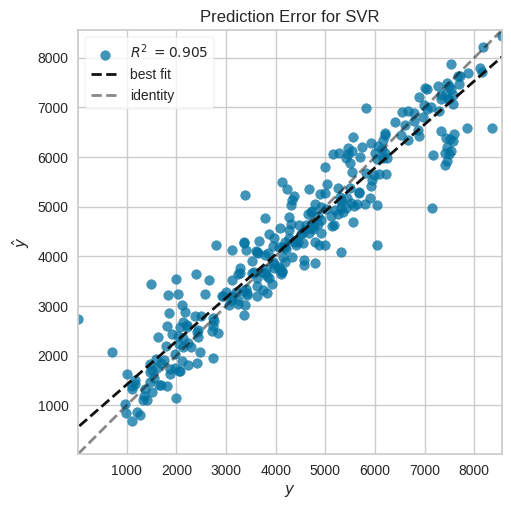

PredictionError(ax=<Axes: title={'center': 'Prediction Error for SVR'}, xlabel='$y$', ylabel='$\\hat{y}$'>,
                estimator=SVR(C=1930.6977288832495, coef0=1, epsilon=9.0,
                              max_iter=25000))

In [100]:
from sklearn.metrics import r2_score
prediction_error(svr_rbf_bayes_search.best_estimator_, X_train_scaled, y_train, X_test_scaled, y_test)

Hemos obtenido una R2 de 0.905, extremadamente alto, esto se puede observar claramente en la figura ya que todos los valores estan muy cerca de la recta ideal. Esto indica que nuestro modelo predice de manera precisa valores nuevos.

Esto también nos indica conjuntamente con el mean_test_score que el modelo está generalizando correctamente los datos y no está capturando demasiado ruido.

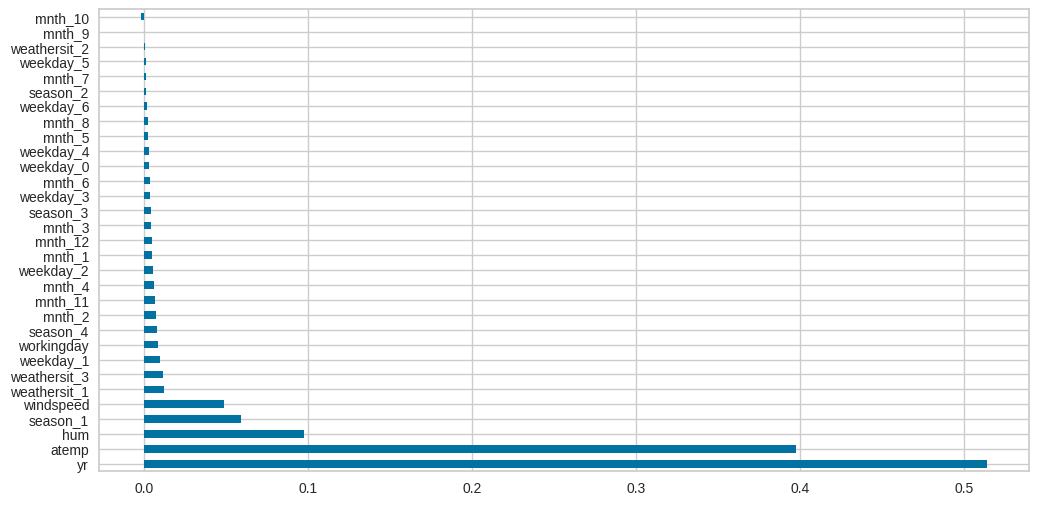

In [101]:
c = choice(X_test_scaled.shape[0], size=X_test_scaled.shape[0], replace=False)
pi = permutation_importance(svr_rbf_bayes_search, X_test_scaled.iloc[c,:], y_test.to_numpy()[c], n_jobs=-1, random_state=42)
var_imp = pd.DataFrame({'importance':pi.importances_mean}, index=X_train_scaled.columns)
var_imp.sort_values(by='importance', ascending=False).plot.barh(figsize=(12,6), legend=False);

Siguiendo la línea de los modelos anteriores, tenemos una importancia principal de year y atemp, en este caso se asemeja más a las del gradient boosting, por eso puede ser que compartan una precisión tan similar. Le sigue hum y season_1 en el orden contrario a al de gradient boosting. Generalmente ha dado mayor peso a las variables numéricas que siguen la distribución gaussiana en comparación con el resto de métodos, hecho que puede haber influido en la mejora respecto los árboles de decisión.

Además, este último modelo sería el elegido para una aplicación que debe predecir en tiempo real a causa de su mejores resultados y su mayor velocidad de predicción. Esta velocidad es mayor dado que los árboles de decisión son generalmente lentos a la hora de predecir, de manera contraria que Gradient Boosting y Random Forest, los cuales han de realizar muchas predicciones hasta llegar a un consenso final de la predicción al tratarse de métodos ensamblados.
